# Modelos generativos

Los modelos generativos son un tipo de modelo no supervisado que permiten aprender distribuciones de datos para luego generar datos nuevos. Son especialmente útiles en contextos donde tomar o simular datos es costoso o lento. Un caso concreto es la simulación en física de partículas, donde herramientas como Geant4 se utilizan para simular las interacciones entre partículas. Si bien Geant4 ofrece resultados de alta precisión, las simulaciones pueden ser computacionalmente costosas, sobre todo cuando se requieren grandes volúmenes de datos. En este contexto, los modelos generativos pueden entrenarse con los datos producidos por Geant4 y luego utilizarse para generar eventos sintéticos de manera mucho más rápida, reduciendo considerablemente los tiempos de simulación.

Los Variational Autoencoders (VAEs) 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 128
transform = transforms.ToTensor()
train_loader = DataLoader(
    datasets.MNIST('./data', train=True, download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

In [3]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, 400)    # 28x28 es tamaño de la imagen aplanada
        self.fc_mu = nn.Linear(400, latent_dim)     # Para la media del espacio latente
        self.fc_logvar = nn.Linear(400, latent_dim) # Para la varianza (log)

    def forward(self, x):
        x = x.view(-1, 28*28)  # aplana la imagen
        h = torch.relu(self.fc1(x))  # paso 1 con activación ReLU
        mu = self.fc_mu(h)          # media
        logvar = self.fc_logvar(h)  # log de la varianza
        return mu, logvar
    
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 400)
        self.fc2 = nn.Linear(400, 28*28)

    def forward(self, z):
        h = torch.relu(self.fc1(z))   # paso 1 con ReLU
        x_recon = torch.sigmoid(self.fc2(h))  # salida con sigmoide para que quede entre 0 y 1
        x_recon = x_recon.view(-1, 1, 28, 28)  # vuelve a forma imagen
        return x_recon


class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)  # desvia la varianza
        eps = torch.randn_like(std)    # ruido random
        return mu + eps * std          

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

# Loss: reconstrucción + KL divergence para que la distribución latente sea normal
def loss_function(x_recon, x, mu, logvar):
    recon_loss = nn.functional.binary_cross_entropy(x_recon, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset MNIST
transform = transforms.ToTensor()
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Modelo y optimizador
latent_dim = 3
vae = VAE(latent_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

nepochs=50
vae.train()
for epoch in range(nepochs):
    total_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(device)
        optimizer.zero_grad()
        x_recon, mu, logvar = vae(x)
        loss = loss_function(x_recon, x, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader.dataset):.4f}")



Epoch 1, Loss: 181.1474
Epoch 2, Loss: 155.6289
Epoch 3, Loss: 151.8230
Epoch 4, Loss: 149.5072
Epoch 5, Loss: 147.8583
Epoch 6, Loss: 146.4698
Epoch 7, Loss: 145.2693
Epoch 8, Loss: 144.3040
Epoch 9, Loss: 143.4458
Epoch 10, Loss: 142.7431
Epoch 11, Loss: 142.1154
Epoch 12, Loss: 141.5591
Epoch 13, Loss: 141.0606
Epoch 14, Loss: 140.5965
Epoch 15, Loss: 140.2017
Epoch 16, Loss: 139.8705
Epoch 17, Loss: 139.5676
Epoch 18, Loss: 139.2595
Epoch 19, Loss: 138.9510
Epoch 20, Loss: 138.7320
Epoch 21, Loss: 138.4819
Epoch 22, Loss: 138.2417
Epoch 23, Loss: 138.0289
Epoch 24, Loss: 137.8574
Epoch 25, Loss: 137.6351
Epoch 26, Loss: 137.4748
Epoch 27, Loss: 137.2948
Epoch 28, Loss: 137.1611
Epoch 29, Loss: 136.9639
Epoch 30, Loss: 136.8365
Epoch 31, Loss: 136.6730
Epoch 32, Loss: 136.5373
Epoch 33, Loss: 136.4531
Epoch 34, Loss: 136.3072
Epoch 35, Loss: 136.1236
Epoch 36, Loss: 136.0457
Epoch 37, Loss: 135.9099
Epoch 38, Loss: 135.7659
Epoch 39, Loss: 135.7472
Epoch 40, Loss: 135.6233
Epoch 41,

In [4]:
num_samples = 16
z = torch.randn(num_samples, latent_dim).to(device)  

vae.eval()
with torch.no_grad():
    generated_imgs = vae.decoder(z).cpu()

Text(0.5, 0.98, 'Números generados por el VAE')

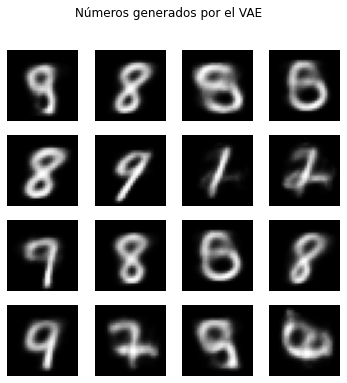

In [5]:
fig, axs = plt.subplots(4, 4, figsize=(6, 6))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(generated_imgs[i].squeeze(), cmap='gray')
    ax.axis('off')
plt.suptitle("Números generados por el VAE")